# Part I: Research Question
## A1
#### Does revenue have any recurring seasonal patterns?
## A2
#### The goal of this analysis is to see if revenue follows a seasonal pattern that could help predict future revenue.

# Part II: Method Justification
## B
#### Time series models have assumptions that include stationarity and autocorrelated. The assumption of stationarity is the data follows a consistent behavior over time. The assumption of autocorrelated is that data points are correlated with data points from the past.

# Part III: Data Preparation

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from dateutil.parser import parse
import warnings
warnings.filterwarnings('ignore')
import os
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api

In [7]:
# Grabbing data from the csv file 
ts = pd.read_csv("C:/Users/cklni/Desktop/WGU/D213/Task 1/teleco_time_series .csv", index_col ='Day', parse_dates = True)

In [8]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731 entries, 1 to 731
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


In [9]:
ts.describe()

,Revenue
count,731.000000
mean,9.822901
std,3.852645
min,0.000000
25%,6.872836
50%,10.785571
75%,12.566911
max,18.154769


In [10]:
ts['Date'] = (pd.date_range(start=datetime(2022, 1, 1),
                           periods=ts.shape[0], freq='24H'))

ts.set_index('Date' ,inplace=True)
ts

,Revenue
Date,
2022-01-01,0.000000
2022-01-02,0.000793
2022-01-03,0.825542
2022-01-04,0.320332
2022-01-05,1.082554
...,...
2023-12-28,16.931559
2023-12-29,17.490666
2023-12-30,16.803638


## C1

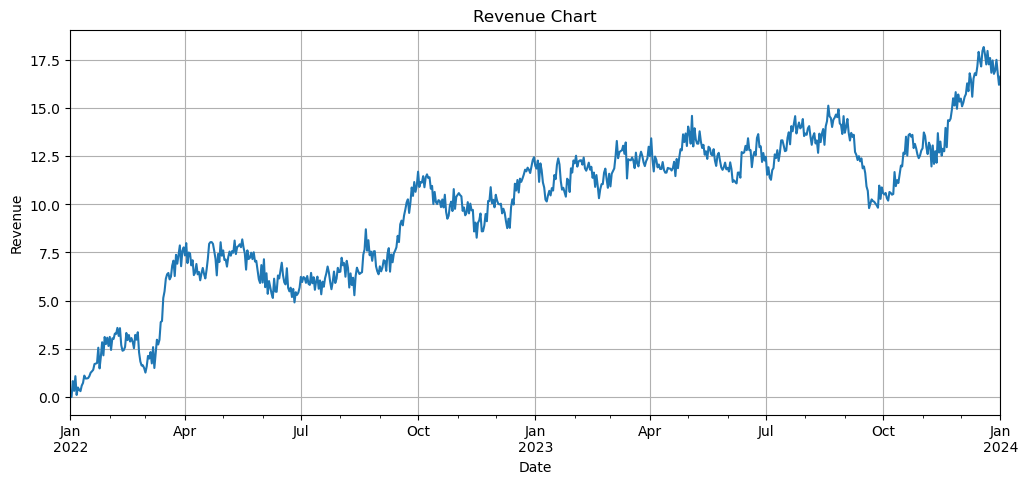

In [11]:
#Time series graph
ts['Revenue'].plot(figsize=(12,5))
plt.title('Revenue Chart')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

In [12]:
ts.isnull().any()

Revenue    False
dtype: bool

In [13]:
ts.isna().sum()

Revenue    0
dtype: int64

## C2
#### In preparing the data I had to format the “Day” into “Date” as it is necessary to have a format such as year-month-date to be able to see seasonal trends instead of having a count of date that does not give information on the time of year. No gaps are present in the above graph. The length of the sequence is from January 1st 2022 to January 1st 2024 with a total of 731 days.

## C3

In [14]:
#Testing stationarity mathematically
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF: ", dftest[0])
    print("2. P-value: ", dftest[1])
    print("3. Num of Lags:", dftest[2])
    print("4. Num of Obs Used for ADF Regression and Critical Values Calc:", dftest[3])
    print("5. Critical Values: ")
    for key, val in dftest[4].items():
        print("\t",key,": ",val)
        
ad_test(ts['Revenue'])

1. ADF:  -1.924612157310183
2. P-value:  0.3205728150793967
3. Num of Lags: 1
4. Num of Obs Used for ADF Regression and Critical Values Calc: 729
5. Critical Values: 
	 1% :  -3.4393520240470554
	 5% :  -2.8655128165959236
	 10% :  -2.5688855736949163


#### The P-value is not less than 0.05, so the dataset does not have stationarity. I will use differencing to help stabilize the mean.

In [15]:
ts_diff = ts.diff().dropna()
ts_diff

,Revenue
Date,
2022-01-02,0.000793
2022-01-03,0.824749
2022-01-04,-0.505210
2022-01-05,0.762222
2022-01-06,-0.974900
...,...
2023-12-28,0.170280
2023-12-29,0.559108
2023-12-30,-0.687028


In [16]:
#Stationarity test after differencing 
result = adfuller(ts_diff['Revenue'])
print("Test statistics: ", result[0])
print("p-value: ", result[1])
print("critical values: ", result[4])

if result[1]<= 0.05:
    print("Reject null hypothesis, the time series is stationary")
else:
    print("Fail to reject null hypothesis, the time series is non-stationary")

Test statistics:  -44.87452719387599
p-value:  0.0
critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
Reject null hypothesis, the time series is stationary


#### The dataset now have a p-value less than the 0.05 critical value. The dataset is now stationary.

## C4
#### Using pandas I imported the teleco time series csv file with Day being my index column. I used info and describe to look at the data’s characteristics and check for nulls. I changed the day column into Dates. Then I checked if the data has stationarity. It did not, so I used the differencing function. I checked for stationarity again and this time the results came back that it is stationary. I will export this clean data in a csv file as it is a requirement in C5. I will split the data into training and test sets with the last 30 days for the test and export each of these into a csv file as required.

In [17]:
print(ts_diff.shape)
x_train = ts_diff.iloc[:-30]
x_test = ts_diff.iloc[-30:]

print('x_train shape', x_train.shape)
print('x_test shape', x_test.shape)

(730, 1)
x_train shape (700, 1)
x_test shape (30, 1)


## C5

In [18]:
#Saving the training and testing data sets
ts_diff.to_csv("C:/Users/cklni/Desktop/WGU/D213/Task 1/D213clean.csv")
x_train.to_csv("C:/Users/cklni/Desktop/WGU/D213/Task 1/Xtrain.csv")
x_test.to_csv("C:/Users/cklni/Desktop/WGU/D213/Task 1/Xtest.csv")

# Part IV: Model Identification and Analysis
## D1

<Axes: xlabel='Date'>

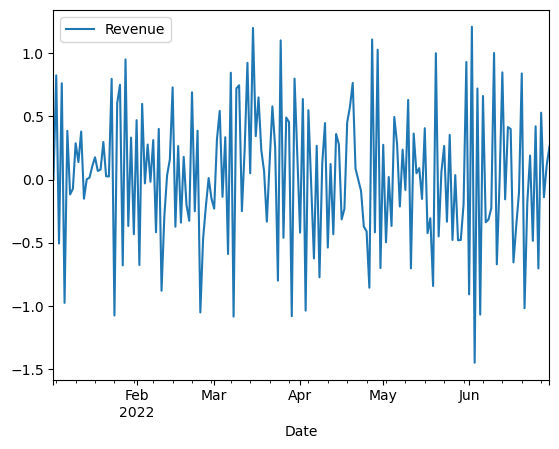

In [19]:
#Checking subset of the data for seasonality
ts_diff.loc[:'2022-06-30'].plot()

#### The above visualization of a subset of the data shows no obvious seasonality.

(array([6.97387711e+03, 3.91439441e+03, 5.47611144e+01, 1.10791953e+01,
        4.25439684e+00, 8.90767103e+00, 9.32436541e+00, 5.07699490e+00,
        4.50820186e+00, 1.97142105e+00, 3.17930644e+00, 2.05465010e+00,
        1.27856111e-01, 9.12357670e-01, 1.58928494e+00, 1.82600308e+00,
        1.37345831e+00, 1.08602805e+00, 3.71664573e-01, 4.01447712e-01,
        6.67019362e-01, 4.28134847e-01, 1.08303874e+00, 5.05461139e-01,
        1.49612021e-01, 2.01156666e-01, 2.01929017e-01, 3.62482513e-02,
        4.74386760e-01, 5.46619399e-01, 2.44460915e-01, 4.75225583e-01,
        2.85007556e-01, 7.59631735e-02, 2.43183009e-01, 7.19503505e-02,
        3.60475608e-01, 2.18971480e-01, 1.23421972e-01, 1.69234109e-01,
        1.69371921e-01, 1.14748035e-01, 2.14144408e-01, 2.82736486e-01,
        3.17059554e-02, 1.62458482e-02, 3.98324693e-02, 6.38895068e-02,
        4.57061837e-02, 6.54718394e-02, 1.72598760e-01, 1.32802101e-01,
        6.74716970e-02, 1.61089989e-02, 1.42266347e-01, 1.236409

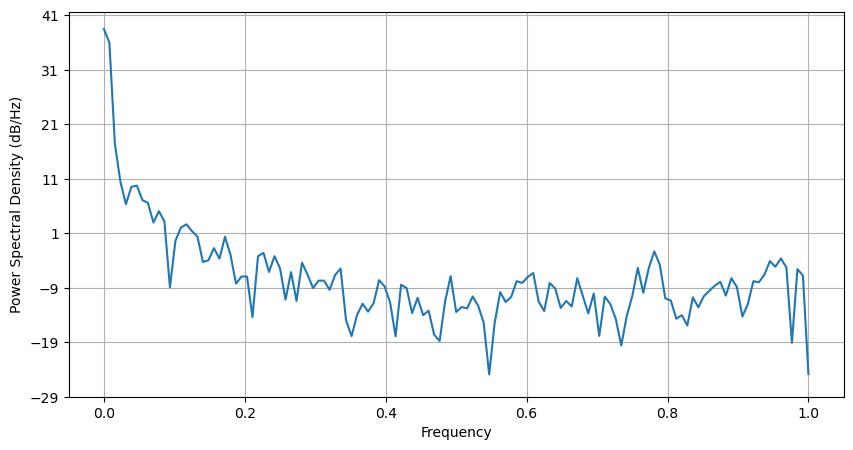

In [20]:
#Spectral analysis on the non-stationary revenue data
plt.figure(figsize=(10,5), linewidth=3)
plt.psd(ts['Revenue'])

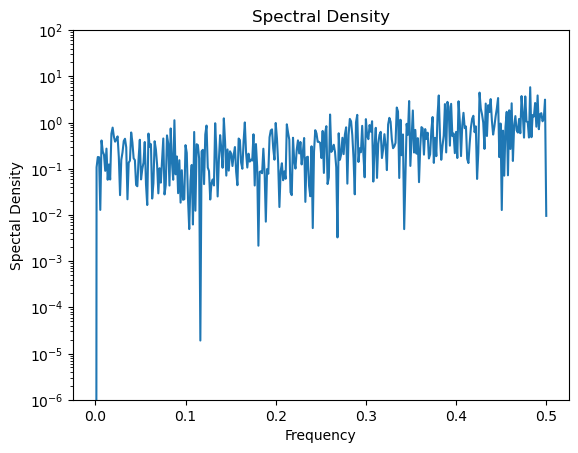

In [21]:
#Spectral analysis on the stationary revenue data
from scipy import signal
f, Pxx_den = signal.periodogram(ts_diff['Revenue'])
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e2])
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectal Density')
plt.show()

#### The spectral density graph above shows a lack of seasonality due to the spikes in it.

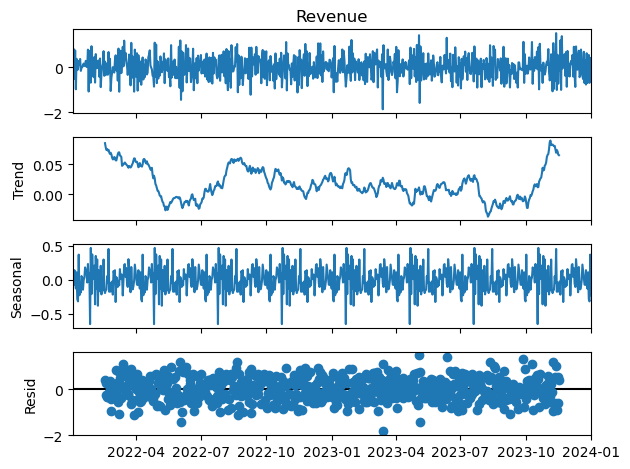

In [22]:
#Decomposition. 
decomp = seasonal_decompose(ts_diff['Revenue'], period=90)


decomp.plot()
plt.show()

#### The above is the decomposed time series. It shows the revenue, trend, seasonality, and residual graphs. 

<Axes: title={'center': 'Seasonality'}, xlabel='Date'>

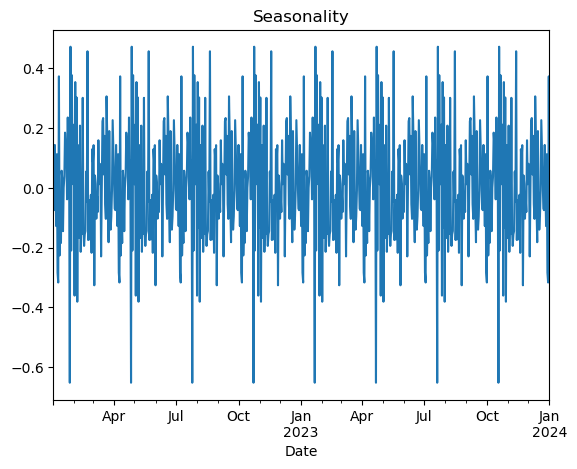

In [23]:
#Plot seasonality from the non-stationary data whose value is in the vairable decomp
plt.title('Seasonality')
decomp.seasonal.plot()

<Axes: title={'center': 'Trend'}, xlabel='Date'>

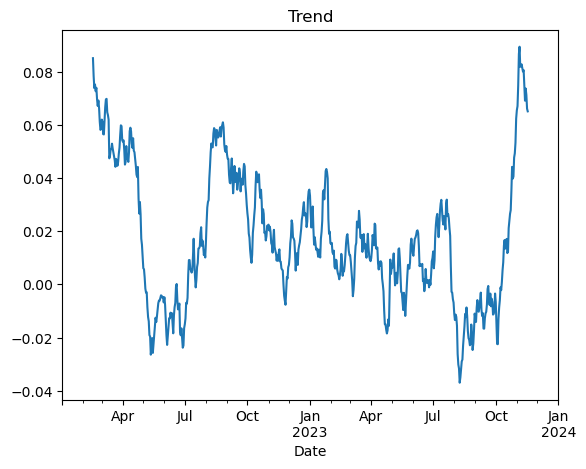

In [24]:
plt.title('Trend')
decomp.trend.plot()

<Axes: title={'center': 'Residuals'}, xlabel='Date'>

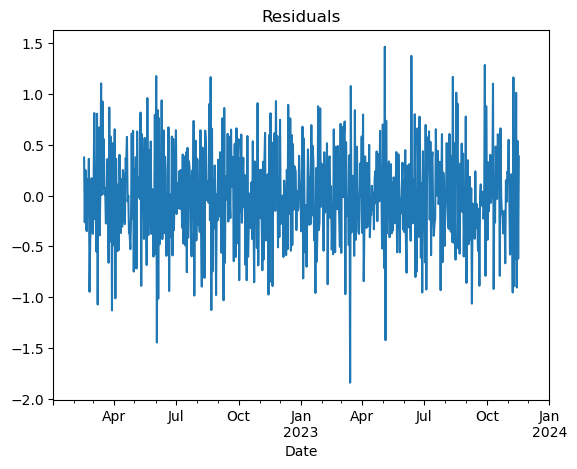

In [25]:
plt.title('Residuals')
decomp.resid.plot()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

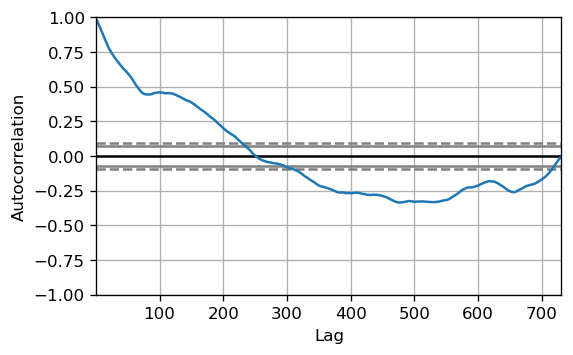

In [26]:
#Autocorrelation on non-stationary data
plt.rcParams.update({'figure.figsize':(5,3), 'figure.dpi':120})
pd.plotting.autocorrelation_plot(ts.Revenue.tolist())

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

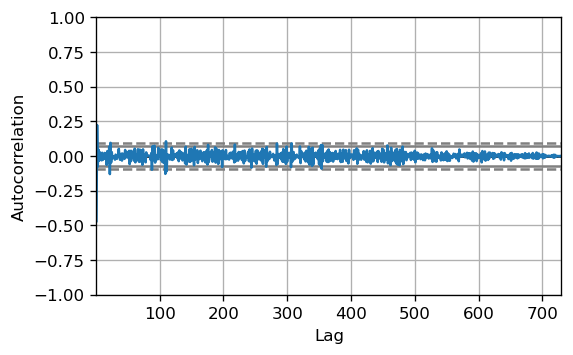

In [27]:
#Autocorrelation on stationary data set
plt.rcParams.update({'figure.figsize':(5,3), 'figure.dpi':120})
pd.plotting.autocorrelation_plot(ts_diff.Revenue.tolist())

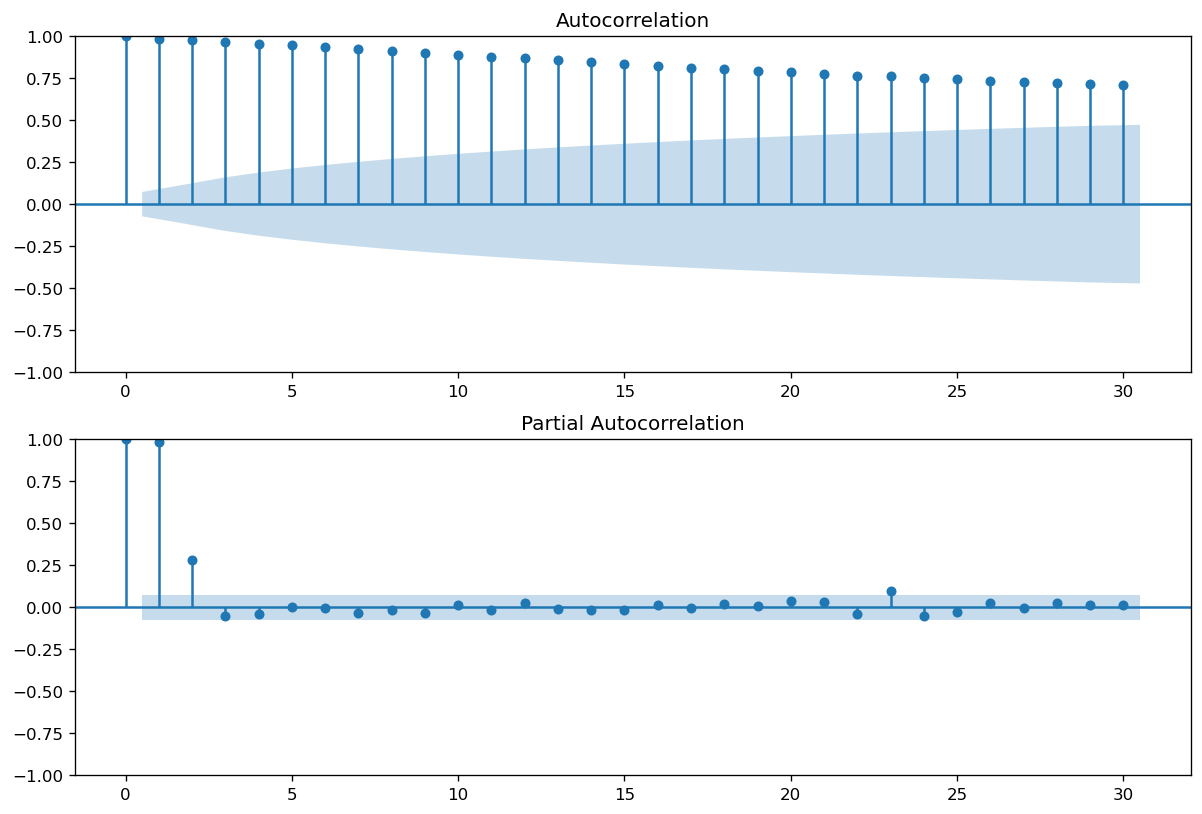

In [28]:
#Graphing ACF plot on non-stationary data 
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts.Revenue, lags=30, ax=ax1)

#Graphing PACF plot on non-stationary data 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts.Revenue, lags=30, ax=ax2)
plt.show()

#### The ACF of the data set before differencing shows a slow decrease in lag, which is another indication of the data being non-stationary. 

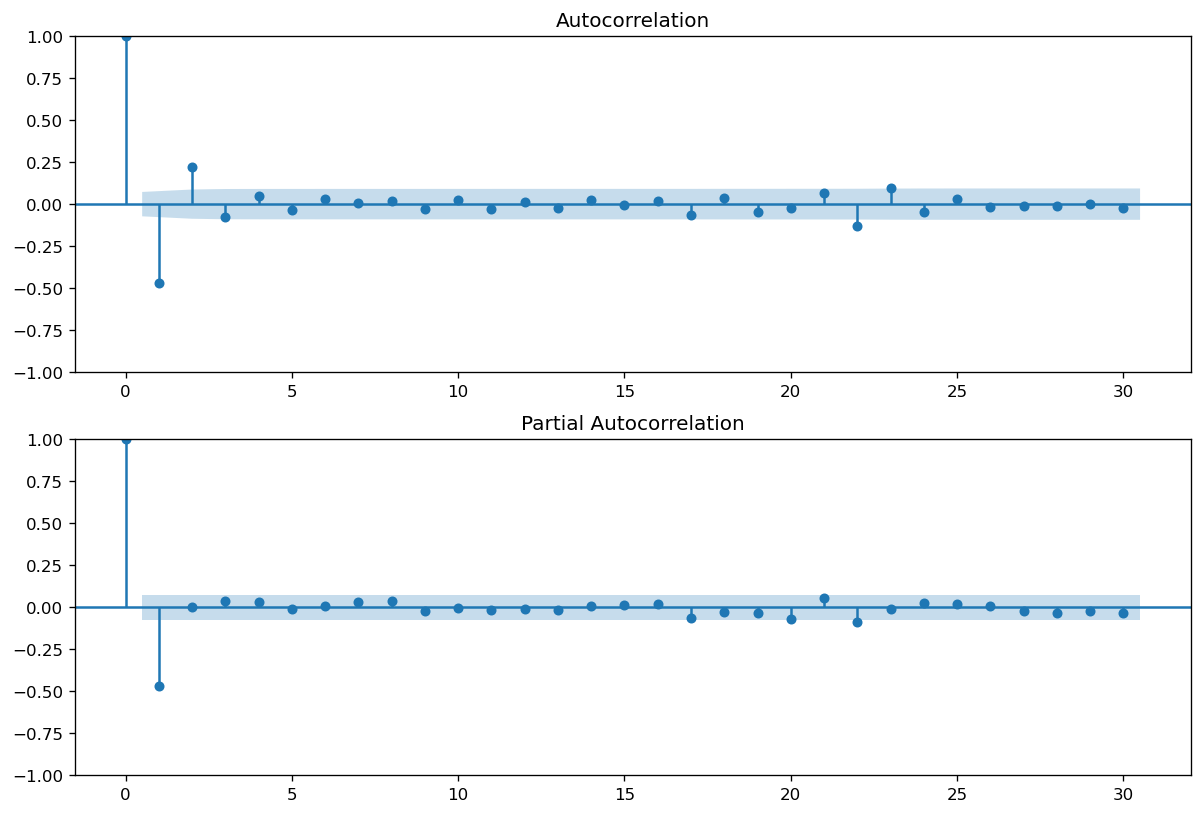

In [29]:
#Graphing ACF plot on stationary data 
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff.Revenue, lags=30, ax=ax1)

#Graphing PACF plot on stationary data 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff.Revenue, lags=30, ax=ax2)
plt.show()

#### The data set after differencing display most of the values in the ACF and PACF in the blue shaded area which means they are not statistically significant.

## D2

In [30]:
from pmdarima import auto_arima
stepwise_fit=auto_arima(ts_diff['Revenue'],trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=987.305, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1162.819, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=983.122, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1019.369, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1162.139, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=985.104, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=985.106, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=986.045, Time=0.55 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=984.710, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.820 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  730
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -488.561
Date:                Wed, 29 May 2024   AIC                            983.122
Time:                        14:04:41   BIC                            996.901
Sample:                    01-02-2022   HQIC                           988.438
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0332      0.018      1.895      0.058      -0.001       0.068
ar.L1         -0.4692      0.033    -14.296      0.000      -0.534      -0.405
sigma2         0.2232      0.013     17.801      0.000       0.199       0.248
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.05
Prob(Q):                              0.96   Prob(JB):                         0.36
Heteroskedasticity (H):               1.02   Skew:                            -0.02
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Using Auto-ARIMA, the best fit model is 1,0,0 with no seasonality 0,0,0, and no periodicity 0.

## D3-D5

In [31]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(x_train['Revenue'],order=(1,0,0))
model = model.fit()
model.summary()

C:\Users\cklni\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\cklni\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\cklni\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  700
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -465.219
Date:                Wed, 29 May 2024   AIC                            936.439
Time:                        14:04:45   BIC                            950.092
Sample:                    01-02-2022   HQIC                           941.716
                         - 12-02-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0217      0.012      1.802      0.072      -0.002       0.045
ar.L1         -0.4737      0.033    -14.216      0.000      -0.539      -0.408
sigma2         0.2211      0.013     17.625      0.000       0.197       0.246
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 1.43
Prob(Q):                              0.80   Prob(JB):                         0.49
Heteroskedasticity (H):               0.97   Skew:                            -0.00
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
start=len(x_train)
end=len(x_train)+len(x_test)-1
pred=model.predict(start=start, end=end, type='levels')
print(pred)
pred.index=ts.index[start:end+1]

2023-12-03    0.223207
2023-12-04   -0.073697
2023-12-05    0.066949
2023-12-06    0.000324
2023-12-07    0.031885
2023-12-08    0.016934
2023-12-09    0.024016
2023-12-10    0.020662
2023-12-11    0.022251
2023-12-12    0.021498
2023-12-13    0.021855
2023-12-14    0.021686
2023-12-15    0.021766
2023-12-16    0.021728
2023-12-17    0.021746
2023-12-18    0.021737
2023-12-19    0.021741
2023-12-20    0.021739
2023-12-21    0.021740
2023-12-22    0.021740
2023-12-23    0.021740
2023-12-24    0.021740
2023-12-25    0.021740
2023-12-26    0.021740
2023-12-27    0.021740
2023-12-28    0.021740
2023-12-29    0.021740
2023-12-30    0.021740
2023-12-31    0.021740
2024-01-01    0.021740
Freq: D, Name: predicted_mean, dtype: float64


<Axes: xlabel='Date'>

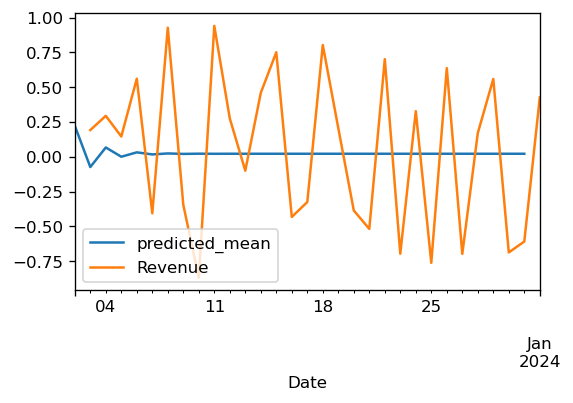

In [33]:
pred.plot(legend=True)
x_test['Revenue'].plot(legend=True)

In [34]:
x_test['Revenue'].mean()

0.051428953333333284

In [35]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred,x_test['Revenue']))
print(rmse)

0.560851128036282


In [36]:
model2=ARIMA(ts_diff['Revenue'],order=(1,0,0))
model2 = model2.fit()
ts_diff.tail()

C:\Users\cklni\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\cklni\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\cklni\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,Revenue
Date,
2023-12-28,0.170280
2023-12-29,0.559108
2023-12-30,-0.687028
2023-12-31,-0.608824
2024-01-01,0.425985


In [37]:
index_future_dates = pd.date_range(start='2024-01-01', end='2025-01-01')
print(index_future_dates)
pred=model2.predict(start=len(ts_diff), end=len(ts_diff)+366, typ='levels').rename('ARIMA Predictions')
pred.index=index_future_dates
print(pred)            

DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09', '2024-01-10',
               ...
               '2024-12-23', '2024-12-24', '2024-12-25', '2024-12-26',
               '2024-12-27', '2024-12-28', '2024-12-29', '2024-12-30',
               '2024-12-31', '2025-01-01'],
              dtype='datetime64[ns]', length=367, freq='D')
2024-01-01   -0.166684
2024-01-02    0.111411
2024-01-03   -0.019078
2024-01-04    0.042151
2024-01-05    0.013421
                ...   
2024-12-28    0.022596
2024-12-29    0.022596
2024-12-30    0.022596
2024-12-31    0.022596
2025-01-01    0.022596
Freq: D, Name: ARIMA Predictions, Length: 367, dtype: float64


<Axes: >

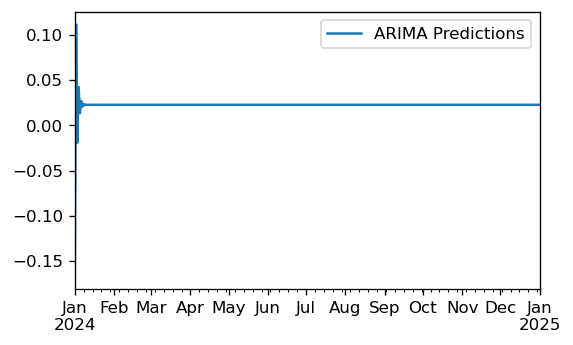

In [38]:
pred.plot(legend=True)

In [39]:
diff_forecast = model2.get_forecast(steps=90)
mean_forecast = diff_forecast.predicted_mean
confidence_intervals = diff_forecast.conf_int()
lower_limits = confidence_intervals.loc[:,'lower Revenue']
upper_limits = confidence_intervals.loc[:,'upper Revenue']

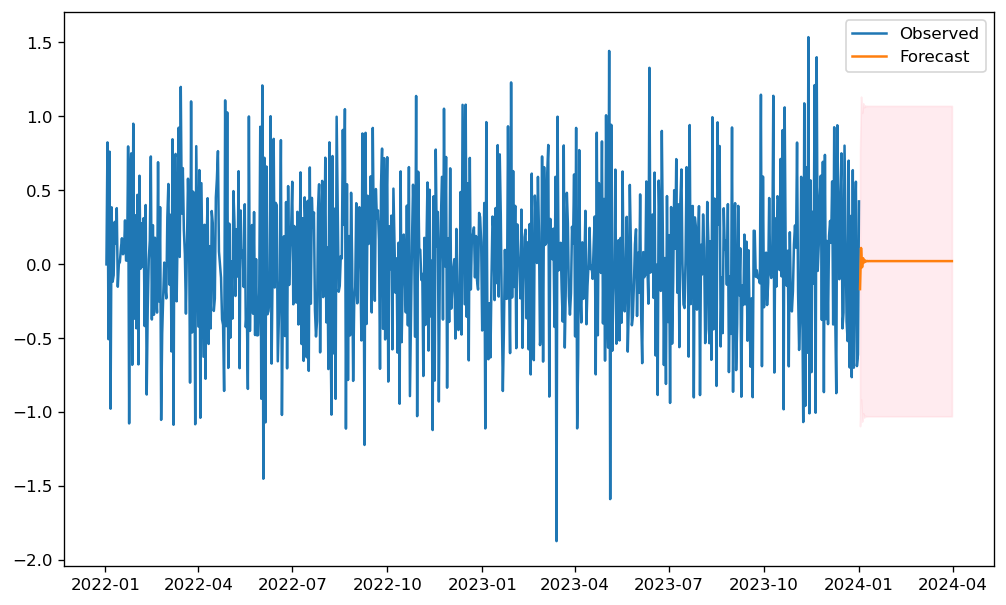

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(ts_diff, label='Observed')
plt.plot(mean_forecast, label='Forecast')
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()

# Part V: Data Summary and Implications
## E1
#### 	The ARIMA model was the correct model to select due to no seasonality being present in the time series. Using Auto-ARIMA, the best fit model is 1,0,0 with no seasonality 0,0,0, and no periodicity 0. The forecast prediction interval is 1 day. Our TM data consists of 2 years of daily revenue. Consequently, the ARIMA model identifies correlations and seasonality to predict revenue daily. The forecast is set to 90 days. The two years of revenue data is good enough to forecast up to a year of future revenue. Setting it to 90 days allows the results to be more accurate than the year but long enough to give good insights as many companies do quarterly revenue calls. As pointed out previously I used Auto-Arima to find the best fit model. Using the root mean squared error, RMSE, which resulted with approximately 0.561. A number closer to 0 would be ideal.  

## E2
#### The annotated visualization of the forecast of the final model compared to the test set is found above in the last graph. 

## E3
#### I would recommend that the company would take these results for the trend of revenue for the next quarter and see how they could expand the company to cause revenue to increase.

In [41]:
pip install nbconvert[webpdf]

Note: you may need to restart the kernel to use updated packages.


In [42]:
pip install pyppeteer

Note: you may need to restart the kernel to use updated packages.


In [43]:
!jupyter nbconvert --to webpdf "Christian LeBlanc D213 Task 1 V1.ipynb" --allow-chromium-download

[NbConvertApp] Converting notebook Christian LeBlanc D213 Task 1 V1.ipynb to webpdf
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 960476 bytes to Christian LeBlanc D213 Task 1 V1.pdf
